# **Project #4 - Food Recognition**
### Deep Learning course - A.Y. 2020-2021
Students:

- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

### Preliminary settings

Check if the runtime is on Colab

In [19]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

Clone the repo in order to access to the dataset if the runtime is on Colab

In [20]:
import os

if IN_COLAB:
    if (os.getcwd() != '/content'):
        %cd ../../

    !git clone https://github.com/gmurro/FoodRecognition.git
    %cd /content/FoodRecognition/src

    # download from drive the weights of the model D if they are problems with Git LFS
    !rm models/model_D/weights_model_D_80e.h5
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BCFCfzb2OvjLP_PDKuq3Wpom2Rbu_SkB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BCFCfzb2OvjLP_PDKuq3Wpom2Rbu_SkB" -O models/model_D/weights_model_D_80e.h5 && rm -rf /tmp/cookies.txt

Import useful libraries

In [1]:
import numpy as np
import random
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import segmentation_utils

### Data acquisition

Define the categories of food on which we want train the segmentation model

In [5]:
cat_names = ['water'
             , 'bread-white'
             , 'salad-leaf-salad-green'
             , 'tomato'
             , 'butter'
             , 'carrot'
             , 'coffee-with-caffeine'
             , 'rice'
             , 'egg'
             , 'mixed-vegetables'
             , 'wine-red'
             , 'apple'
             , 'jam'
             , 'potatoes-steamed'
             , 'banana'
             , 'cheese' ]
             
batch_size = 32
img_size = (128,128)
num_classes = len(cat_names) + 1

Load test set

In [6]:
# @title Load test set
path_dir = "../data/test/"   # @param {type: "string"}

# load images and other info from annotations
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_label = segmentation_utils.load_imgs(coco, cat_names)

# LOAD TEST DATA
x, y = segmentation_utils.load_data(coco, path_dir+"images/", img_size, cat_names)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Loading images:
546/554 [============================>.] - ETA: 0s
Loading masks:
552/554 [============================>.] - ETA: 0s

## Model loading

Load of model architectures

In [7]:
from tensorflow.keras.models import model_from_json

# load json and create model
models = []
n_models = 4
for i in range(65,65+n_models):
    json_file = open('models/model_'+chr(i)+'/model_'+chr(i)+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    models.append(model_from_json(loaded_model_json))

Load of pretrained weights

In [11]:
for i in range(n_models):
    models[i].load_weights('models/model_'+chr(i+65)+'/weights_model_'+chr(i+65)+'_80e.h5')

## Prediction

Make predictions

In [12]:
preds=[]
for i in range(n_models):
    preds.append(models[i].predict(x))

## Functions implementation

Binarization of the predicted mask in function of a threshold

In [13]:
def binarize(pred, thresold):
   return np.where(pred > thresold, 1, 0)

Function to compute the IoU

In [14]:
from keras import backend as krs

def iou_comp(y_true, y_pred,smooth):
    """
    Comput the Intersection over Union (IoU).
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        smooth: smoothing parameter in order to avoid division by zero
    Returns:
        the IoU for the given y_pred on the y_true
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = krs.cast(krs.equal(y_true, 1), krs.floatx())
    y_pred = krs.cast(krs.equal(y_pred, 1), krs.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = krs.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = krs.sum(y_true) + krs.sum(y_pred) - intersection
    # avoid divide by zero adding the smooth
    # otherwise, return the intersection over union
    return (intersection / (union+smooth))

Metric calculation function

In [15]:
def metrics(ground_truths,predictions,num_classes,with_background=True,smooth=0.000001):
    """
    Return the metrics values for the dataset computed as the mean of the metrics of every image.
    Args:
        ground_truths: the expected mask as one-hot 
        predictions: the predicted mask
        num_classes: number of classes to classify
        with_background: boolean that indicate if the background channel must be included in the computation of metrics
        smooth: smoothing parameter for the IoU computation
    Returns:
        the mean of each metric for the entire dataset of images and the meanIoU for every category
    """
    r = tf.keras.metrics.Recall()
    p = tf.keras.metrics.Precision()
    
    if(with_background):
        start=0
    else:
        start=1
        
    #Record lists of every mean IoU of every single image metric
    precision_imgs=[]
    recall_imgs =[]
    iou_imgs =[]
    
    #Channels record lists
    iou_channels=[]
    prec_channels=[]
    rec_channels=[]
    
    for img in range(len(ground_truths)):
        
        #initialized the channels record lists with as much empty lists to dimension
        #of all classes in order to compute the mean correctly
        for i in range(start,num_classes-start):
            iou_channels.append([])
            prec_channels.append([])
            rec_channels.append([])

        #record of mean of metrics values for every category
        iou_cat=[]
        prec_cat=[]
        rec_cat=[]
        
        #record lists of the single image
        iou_single_img=[]
        rec_single_img=[]
        prec_single_img=[]


        for ch in range(start,num_classes-start):
            if(np.any(ground_truths[img,:,:,ch]) or np.any(np.float32(predictions)[img,:,:,ch])):
                
                #compute the IoU and save it into the channel record list and the record list of the single image
                iou_ch=iou_comp(ground_truths[img,:,:,ch],np.float32(predictions)[img,:,:,ch],smooth)
                #Save this value in the image record
                iou_single_img.append(iou_ch)
                #Save this value in the category record
                iou_channels[ch].append(iou_ch)
                
                #compute the recall and save it into the channel record list and the record list of the single image
                r.update_state(ground_truths[img,:,:,ch],np.float32(predictions)[img,:,:,ch])
                rec_ch = r.result().numpy()
                #Save this value in the image record
                rec_single_img.append(rec_ch)
                #Save this value in the category record
                rec_channels[ch].append(rec_ch)
                #reset the state of recall calculus
                r.reset_state()
                
                #compute the precision and save it into the channel record list and the record list of the single image
                p.update_state(ground_truths[img,:,:,ch],np.float32(predictions)[img,:,:,ch])
                prec_ch = p.result().numpy()
                #Save this value in the image record
                prec_single_img.append(prec_ch)
                #Save this value in the category record
                prec_channels[ch].append(prec_ch)
                #reset the state of precision calculus
                p.reset_state()
        
        #Put the mean of Iou of this image categories in the record list for every image,
        #if not present any iou calculation put 0 for that image
        if(len(iou_single_img)!=0):
            iou_imgs.append(np.mean(iou_single_img))
        else:
            iou_imgs.append(0)

        #Put the mean of precision of this image categories in the record list for every image,
        #if not present any iou calculation put 0 for that image
        if(len(prec_single_img)!=0):
            precision_imgs.append(np.mean(prec_single_img))
        else:
            precision_imgs.append(0)
        
        #Put the mean of recall of this image categories in the record list for every image,
        #if not present any iou calculation put 0 for that image
        if(len(rec_single_img)!=0):
            recall_imgs.append(np.mean(rec_single_img))
        else:
            recall_imgs.append(0)

    
    for cat in range(start,num_classes-start):
        #Append in the IoU the mean of the values for that category
        #If the list is empty append 0
        if (len(iou_channels[cat])==0):
            iou_channels[cat].append(0)
        iou_cat.append(np.mean(iou_channels[cat]))
        
        #Append in the precision the mean of the values for that category
        #If the list is empty append 0
        if (len(prec_channels[cat])==0):
            prec_channels[cat].append(0)
        prec_cat.append(np.mean(prec_channels[cat]))
        
        #Append in the recall the mean of the values for that category
        #If the list is empty append 0
        if (len(rec_channels[cat])==0):
            rec_channels[cat].append(0)
        rec_cat.append(np.mean(rec_channels[cat]))
        
    #compute final values of iou,recall and precision as mean over all images values
    m_iou=np.mean(iou_imgs)
    m_recall=np.mean(recall_imgs)
    m_precision=np.mean(precision_imgs)

    return m_iou,m_precision,m_recall,iou_cat,prec_cat,rec_cat

Plotting functions

In [16]:
import matplotlib.pyplot as plt
def plot_model_metrics(metric,axes_x_list,keys, labels,title="Results",figsize=(10,5)):
    
    fig = plt.figure(figsize=figsize)

    for mod in range(len(keys)):
        plt.plot(axes_x_list,metric[mod])
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(keys,
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title(title)
    plt.grid(True)
    plt.tick_params(axis='x',which='major', labelrotation=-90)
    plt.show()
    

Function to show partial results

In [17]:
def partial_dataset_results(min,max,dataset,ground_truths,predictions,cat_names,num_classes,num_models,with_background:True):
    """
    Return the metrics values for the dataset computed as the mean of the metrics of every image.
    Args:
        min: starting index of the part of dataset to analize
        max: ending index of the part dataset of dataset to analize
        dataset: the image dataset
        ground_truths: the expected mask as one-hot 
        predictions: the predicted masks
        cat_names: list with the name of all category
        num_classes: number of classes to classify
        with_background: boolean that indicate if the background channel must be included in the computation of metrics
    Returns:
        it prints the single image and print the mean of each metric for the partial dataset of images
        and the meanIoU for every category.
    """
    print("--------------------------------------------")
    images_ious=np.zeros(((max-min),n_models))
    images_precisions=np.zeros(((max-min),n_models))
    images_recalls=np.zeros(((max-min),n_models))
    for i in range(min,max):
        segmentation_utils.show_mask(dataset[i]/255, ground_truths[i,:,:,:], cat_names, figsize=(3,3))
        for mod in range(num_models):
            print("MODEL_{}".format(chr(mod+65)))
            prediction=preds[mod]
            segmentation_utils.show_mask(dataset[i]/255, binarize(prediction[i], 0.4), cat_names, figsize=(3,3))
            iou,precision,recall,iou_cat,prec_cat,rec_cat = metrics(ground_truths[i:i+1],np.float32(binarize(prediction, 0.4)[i:i+1]),num_classes,with_background)
            images_ious[i][mod]=iou
            images_precisions[i][mod]=precision
            images_recalls[i][mod]=recall
            print("MeanIoU: {0:.3f}".format(iou))
            print("MeanPrecision: {0:.3f}".format(precision))
            print("MeanRecall: {0:.3f}".format(recall))
            print("--------------------------------------------")
        m=[images_ious[i],images_precisions[i],images_recalls[i]]
        plot_model_metrics(m,["model_A","model_B","model_C","model_D"],["iou","precision","recall"],labels=("model","metric_value"),title="Metrics of image {}".format(i),figsize=(5,2.5))
        

Show the values of the evaluation metrics for every model

In [18]:
#Record list for the models
models_iou=np.zeros((n_models))
models_precision=np.zeros((n_models))
models_recall=np.zeros((n_models))
models_iou_cat=[]
models_rec_cat=[]
models_prec_cat=[]

print("--------------------------------------")
for i in range(n_models):
    print("MODEL_{}".format(chr(i+65)))
    iou,precision, recall, iou_cat, prec_cat, rec_cat = metrics(y,np.float32(binarize(preds[i], 0.4)),num_classes,True)
    models_iou[i]=iou
    models_precision[i]=precision
    models_recall[i]=recall
    models_iou_cat.append(iou_cat)
    models_prec_cat.append(prec_cat)
    models_rec_cat.append(rec_cat)
    print("MeanIoU: {0:.3f}".format(iou))
    print("MeanPrecision: {0:.3f}".format(precision))
    print("MeanRecall: {0:.3f}".format(recall))
    print("--------------------------------------")

--------------------------------------
MODEL_A
MeanIoU: 0.488
MeanPrecision: 0.591
MeanRecall: 0.559
--------------------------------------
MODEL_B
MeanIoU: 0.525
MeanPrecision: 0.618
MeanRecall: 0.591
--------------------------------------
MODEL_C
MeanIoU: 0.455
MeanPrecision: 0.549
MeanRecall: 0.526
--------------------------------------
MODEL_D
MeanIoU: 0.624
MeanPrecision: 0.703
MeanRecall: 0.688
--------------------------------------


### Results

Show two examples of the predictions

--------------------------------------------


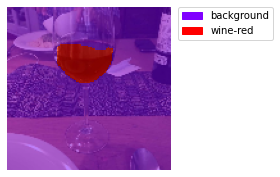

MODEL_A


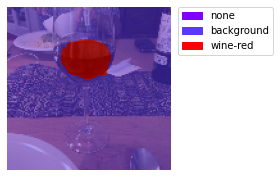

MeanIoU: 0.847
MeanPrecision: 0.921
MeanRecall: 0.903
--------------------------------------------
MODEL_B


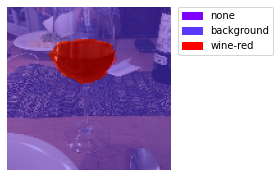

MeanIoU: 0.862
MeanPrecision: 0.872
MeanRecall: 0.990
--------------------------------------------
MODEL_C


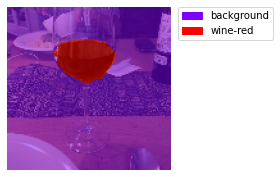

MeanIoU: 0.891
MeanPrecision: 0.906
MeanRecall: 0.982
--------------------------------------------
MODEL_D


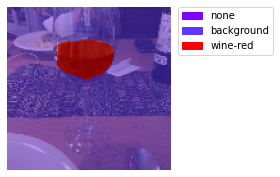

MeanIoU: 0.876
MeanPrecision: 0.913
MeanRecall: 0.950
--------------------------------------------


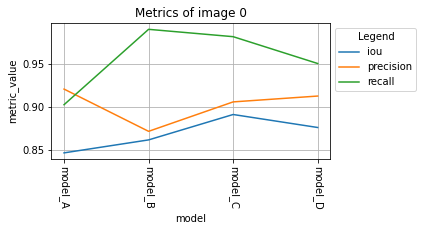

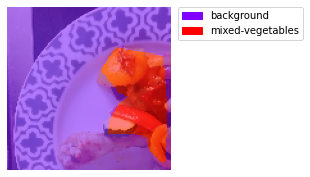

MODEL_A


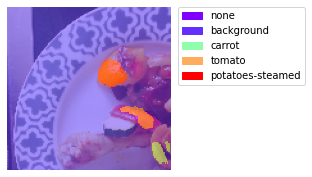

MeanIoU: 0.169
MeanPrecision: 0.170
MeanRecall: 0.199
--------------------------------------------
MODEL_B


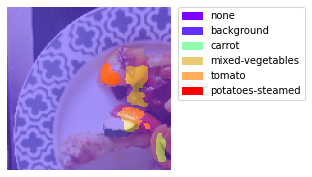

MeanIoU: 0.207
MeanPrecision: 0.368
MeanRecall: 0.239
--------------------------------------------
MODEL_C


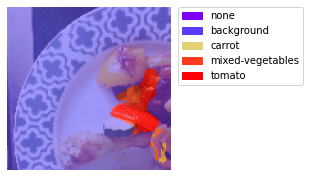

MeanIoU: 0.235
MeanPrecision: 0.433
MeanRecall: 0.268
--------------------------------------------
MODEL_D


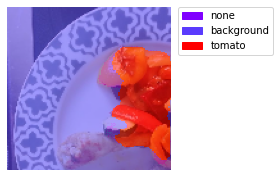

MeanIoU: 0.315
MeanPrecision: 0.329
MeanRecall: 0.319
--------------------------------------------


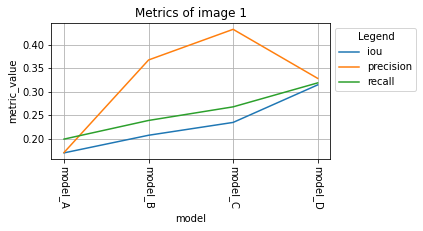

In [22]:
partial_dataset_results(0,2,x,y,preds,cat_names,num_classes,n_models,True)

Show the mean of IoU for every category

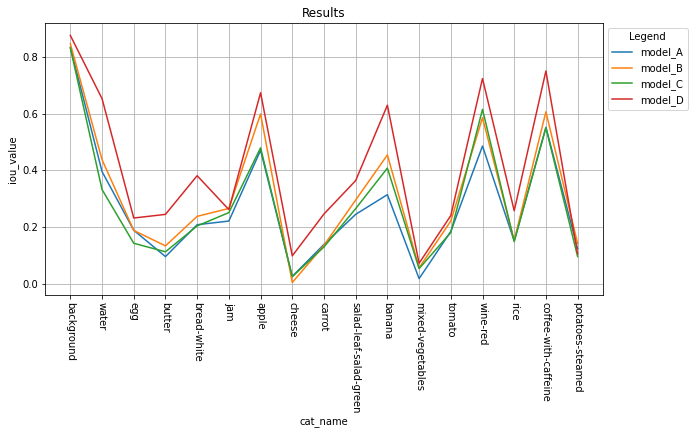

In [23]:
plot_model_metrics(models_iou_cat,cat_names,["model_A","model_B","model_C","model_D"],("cat_name", "iou_value"))

Show the mean of precision for every category

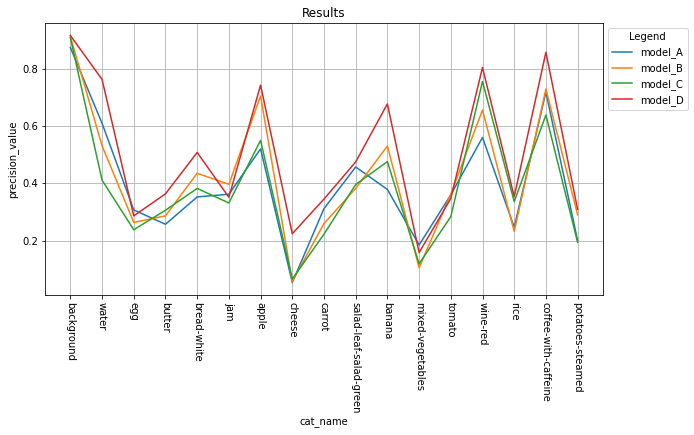

In [24]:
plot_model_metrics(models_prec_cat,cat_names,["model_A","model_B","model_C","model_D"],("cat_name", "precision_value"))

Show the mean of recall for every category

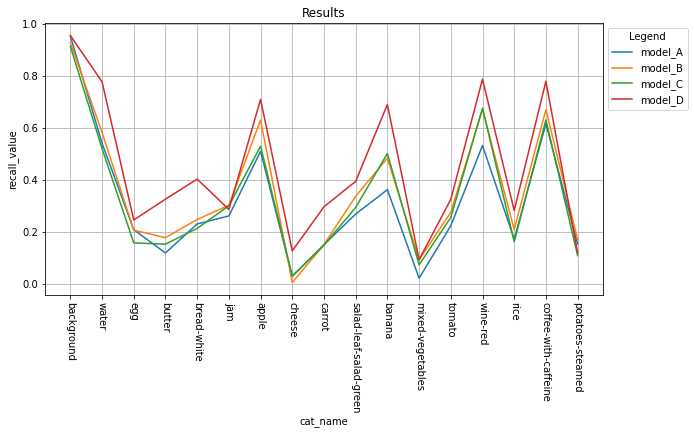

In [25]:
plot_model_metrics(models_rec_cat,cat_names,["model_A","model_B","model_C","model_D"],("cat_name", "recall_value"))